# Sound classification using a k-NN classifier - Markús Freyr Sigurbjörnsson


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install essentia

     |████████████████████████████████| 11.7MB 4.0MB/s 


In [ ]:
import sys, os
import cython
import json
import numpy as np

from scipy.signal import get_window
from scipy.fftpack import fft, fftshift
from scipy import signal

from sklearn import preprocessing

import essentia
import essentia.standard as es

from matplotlib.lines import Line2D
from scipy.cluster.vq import vq, kmeans, whiten

import math
import matplotlib.pyplot as plt

#sys.path.append('../software/models/')
sys.path.append('drive/MyDrive/sms-tools/software/models')
import stft
import utilFunctions as UF

import IPython.display as ipd

#sys.path.append('../../freesound-python/')  # directory were you installed the freesound-python repository
sys.path.append('drive/MyDrive/freesound-python-master/')
import freesound as fs

descriptors = [ 'lowlevel.spectral_centroid.mean',
                'lowlevel.spectral_contrast.mean',
                'lowlevel.dissonance.mean',
                'lowlevel.hfc.mean',
                'lowlevel.mfcc.mean',
                'sfx.logattacktime.mean',
                'sfx.inharmonicity.mean']

## part 1
I got the sound https://freesound.org/people/barisbozkurt/sounds/140288/. description of this sound is someone playing the bendir in three different ways. 

In [ ]:
def read_audio_file(input_file):
    return UF.wavread(input_file)

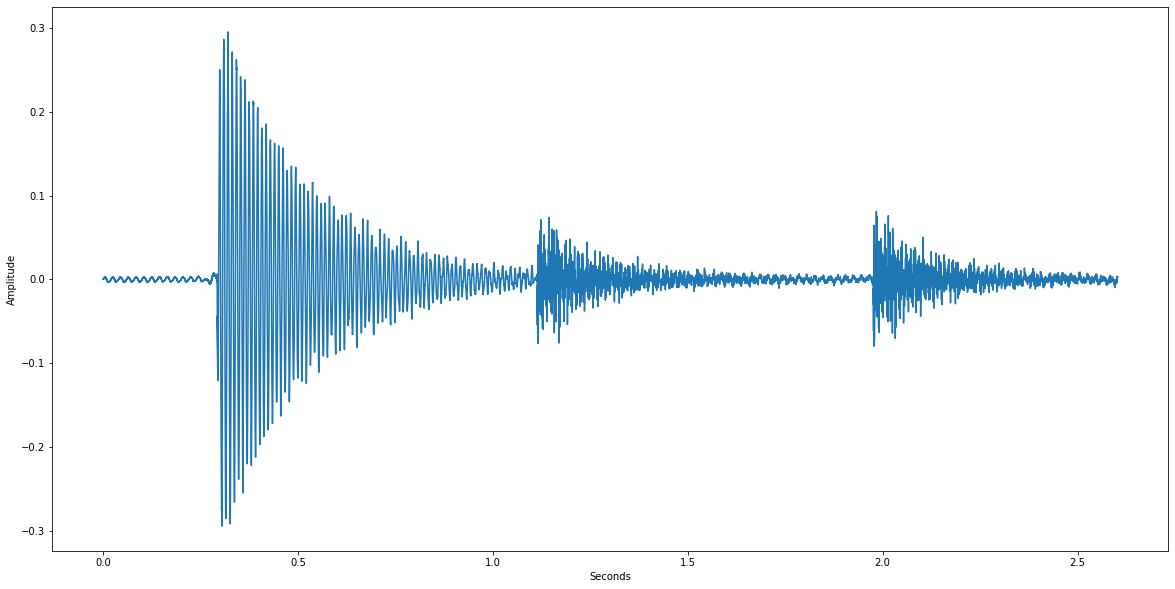

In [ ]:
def plot_and_play_audio(input_file):
    fs, x = UF.wavread(input_file)

    plt.figure(figsize=(20,10))
    plt.plot(np.arange(len(x))/fs,x)
    plt.xlabel('Seconds')
    plt.ylabel('Amplitude')

    ipd.display(ipd.Audio(data=x, rate=fs))

plot_and_play_audio('drive/MyDrive/sms-tools/sounds/barisbozkurt__senginsemai-bendir.wav')

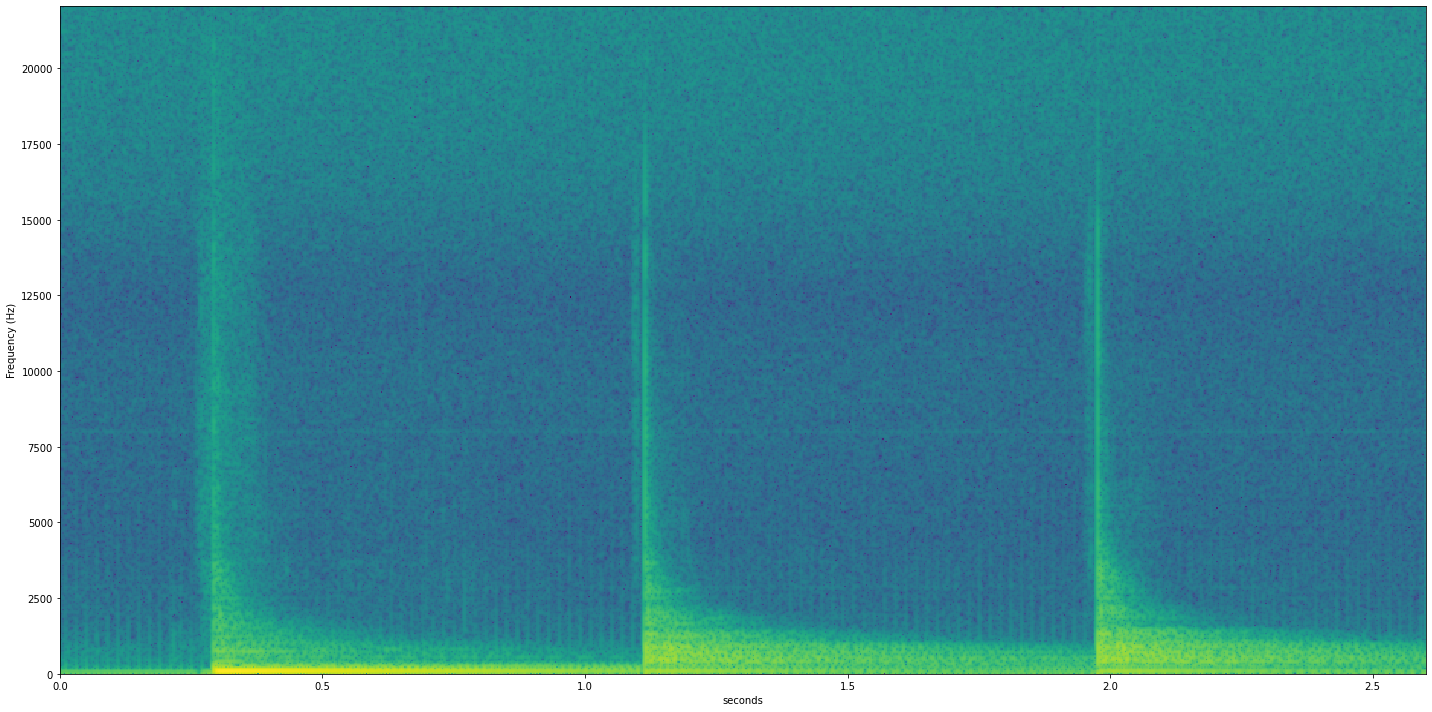

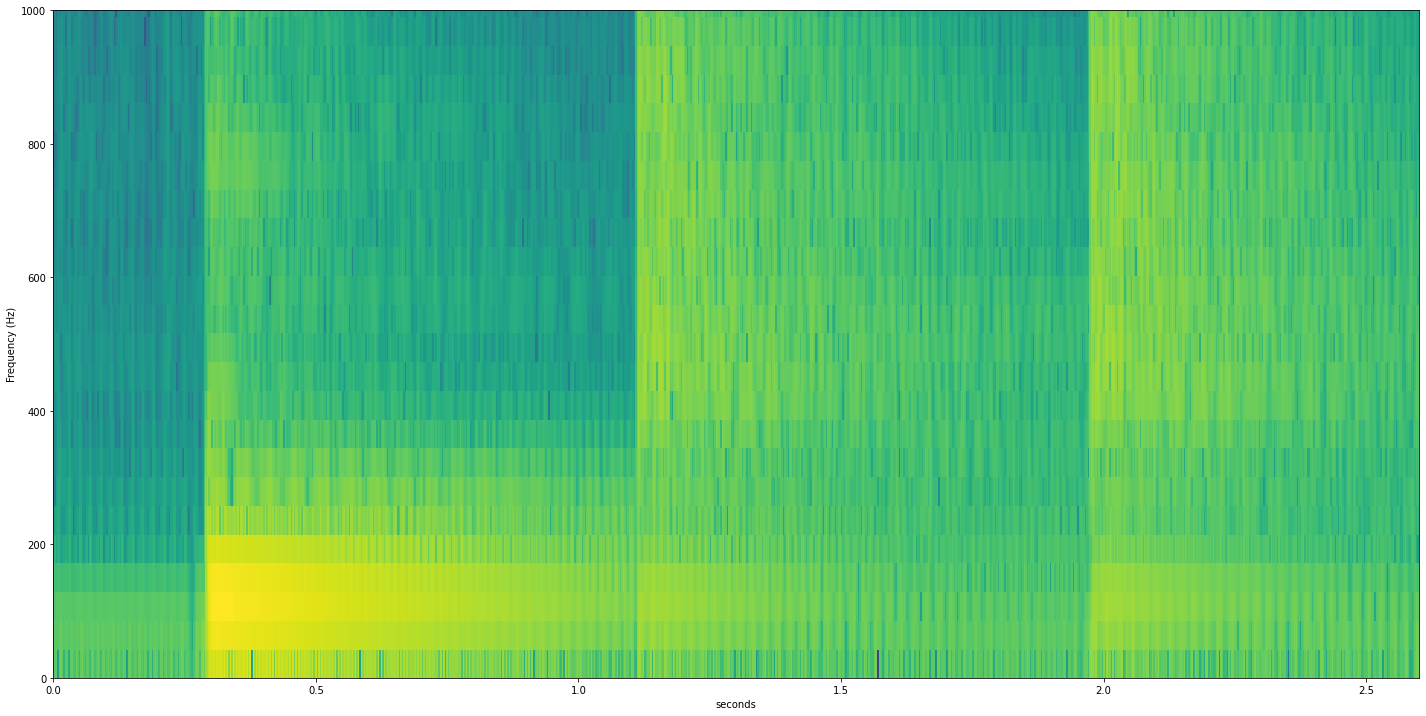

In [ ]:
def plot_stft(input_file, window, M, N, H):
    fs, x = UF.wavread(input_file)
    w = get_window(window, M)
    mX, pX = stft.stftAnal(x, w, N, H)


    numFrames = int(mX[:,0].size)
    frmTime = H*np.arange(numFrames)/float(fs)  
    binFreq = np.arange(N/2+1)*float(fs)/N 
    plt.figure(figsize=(20,10))
    plt.xlabel('seconds')
    plt.ylabel('Frequency (Hz)')
    plt.pcolormesh(frmTime, binFreq, np.transpose(mX))
    plt.autoscale(tight=True)
    plt.tight_layout()

    numFrames = int(mX[:,0].size)
    frmTime = H*np.arange(numFrames)/float(fs)  
    binFreq = np.arange(N/2+1)*float(fs)/N 
    plt.figure(figsize=(20,10))
    plt.xlabel('seconds')
    plt.ylabel('Frequency (Hz)')
    plt.pcolormesh(frmTime, binFreq, np.transpose(mX))
    plt.autoscale(tight=True)
    plt.tight_layout()
    plt.ylim(0, 1000)

    

plot_stft('drive/MyDrive/sms-tools/sounds/barisbozkurt__senginsemai-bendir.wav', 'blackmanharris', 901, 1024,128 )


original song was a sequence of three different playing styles of the bendir. I chose the first 2.6 seconds of the sound, which is the first sequence of the first playing style because it showcases the best the sound that the bendir produces. the sound consists of three hits on the drum, first hit on the drum, you can perceive a pitch in the sound but the next two hits on the drum you cant perceive a pitch. Looking at the plot of the waveform of the sound you can see it looks very percussive, sharp attack, and decays like a percussion instrument. Also looking at the plot of the waveform you can see that the first hit on the drum looks harmonic but the other two are very stochastic. We can confirm that when we look at the spectrogram of the sound we can see that the first hit on the drum is the only sound that has a fundemental frequency and the other two are very stochastic. we can see that the fundemental frequency is about 40 - 180 Hz. The harmonic model would only be useful for the first hit one the drum. Using the sinusoidal-residual model, most of the sound would just be resudual.


## part 2 - option c

I downloaded three different types of sound from freesound. Hi-Hat, bass drum and snare. The bendir is a percussion instruments. The bendir is a traditional instrument that is played throughout North Africa, as well as in Sufi ceremonies; it was played, too, in Ancient Egypt and Mesopotamia. In Turkish, the word bendir means "a big hand frame drum".

In [ ]:
def download_sounds_freesound(queryText = "", tag=None, duration=None, API_Key = "", outputDir = "", topNResults = 5, featureExt = '.json'):
  """
  This function downloads sounds and their descriptors from freesound using the queryText and the 
  tag specified in the input. Additionally, you can also specify the duration range to filter sounds 
  based on duration.
  
  Inputs:
        (Input parameters marked with a * are optional)
        queryText (string): query text for the sounds (eg. "violin", "trumpet", "cello", "bassoon" etc.)
        tag* (string): tag to be used for filtering the searched sounds. (eg. "multisample",  
                       "single-note" etc.)
        duration* (tuple): min and the max duration (seconds) of the sound to filter, eg. (0.2,15)
        API_Key (string): your api key, which you can obtain from : www.freesound.org/apiv2/apply/
        outputDir (string): path to the directory where you want to store the sounds and their 
                            descriptors
        topNResults (integer): number of results(sounds) that you want to download 
        featureExt (string): file extension for storing sound descriptors
  output:
        This function downloads sounds and descriptors, and then stores them in outputDir. In 
        outputDir it creates a directory of the same name as that of the queryText. In this 
        directory outputDir/queryText it creates a directory for every sound with the name 
        of the directory as the sound id. Additionally, this function also dumps a text file 
        containing sound-ids and freesound links for all the downloaded sounds in the outputDir. 
        NOTE: If the directory outputDir/queryText exists, it deletes the existing contents 
        and stores only the sounds from the current query. 
  """ 
  
  # Checking for the compulsory input parameters
  if queryText == "":
    print("\n")
    print("Provide a query text to search for sounds")
    return -1
    
  if API_Key == "":
    print("\n")
    print("You need a valid freesound API key to be able to download sounds.")
    print("Please apply for one here: www.freesound.org/apiv2/apply/")
    print("\n")
    return -1
    
  if outputDir == "" or not os.path.exists(outputDir):
    print("\n")
    print("Please provide a valid output directory. This will be the root directory for storing sounds and descriptors")
    return -1    
  
  # Setting up the Freesound client and the authentication key
  fsClnt = fs.FreesoundClient()
  fsClnt.set_token(API_Key,"token")  
  
  # Creating a duration filter string that the Freesound API understands
  if duration and type(duration) == tuple:
    flt_dur = " duration:[" + str(duration[0])+ " TO " +str(duration[1]) + "]"
  else:
    flt_dur = ""
 
  if tag and type(tag) == str:
    flt_tag = "tag:"+tag
  else:
    flt_tag = ""

  # Querying Freesound
  page_size = 30
  if not flt_tag + flt_dur == "":
    qRes = fsClnt.text_search(query=queryText ,filter = flt_tag + flt_dur,sort="score", fields="id,name,previews,username,url,analysis", descriptors=','.join(descriptors), page_size=page_size, normalized=1)
  else:
    qRes = fsClnt.text_search(query=queryText ,sort="score",fields="id,name,previews,username,url,analysis", descriptors=','.join(descriptors), page_size=page_size, normalized=1)
  
  outDir2 = os.path.join(outputDir, queryText)
  if os.path.exists(outDir2):             # If the directory exists, it deletes it and starts fresh
      os.system("rm -r " + outDir2)
  os.mkdir(outDir2)

  pageNo = 1
  sndCnt = 0
  indCnt = 0
  totalSnds = min(qRes.count,200)   # System quits after trying to download after 200 times
  
  # Creating directories to store output and downloading sounds and their descriptors
  downloadedSounds = []
  while(1):
    if indCnt >= totalSnds:
      print("Not able to download required number of sounds. Either there are not enough search results on freesound for your search query and filtering constraints or something is wrong with this script.")
      break
    sound = qRes[indCnt - ((pageNo-1)*page_size)]
    print("Downloading mp3 preview and descriptors for sound with id: %s"%str(sound.id))
    outDir1 = os.path.join(outputDir, queryText, str(sound.id))
    if os.path.exists(outDir1):
      os.system("rm -r " + outDir1)
    os.system("mkdir " + outDir1)
    
    mp3Path = os.path.join(outDir1,  str(sound.previews.preview_lq_mp3.split("/")[-1]))
    ftrPath = mp3Path.replace('.mp3', featureExt)
    
    try:
      
      fs.FSRequest.retrieve(sound.previews.preview_lq_mp3, fsClnt, mp3Path)
      # Initialize a dictionary to store descriptors
      features = {}
      # Obtaining all the descriptors
      for desc in descriptors:
        features[desc]=[]
        features[desc].append(eval("sound.analysis."+desc))
      
      # Once we have all the descriptors, store them in a json file
      json.dump(features, open(ftrPath,'w'))
      sndCnt+=1
      downloadedSounds.append([str(sound.id), sound.url])

    except:
      if os.path.exists(outDir1):
        os.system("rm -r " + outDir1)
    
    indCnt +=1
    
    if indCnt%page_size==0:
      qRes = qRes.next_page()
      pageNo+=1
      
    if sndCnt>=topNResults:
      break
  # Dump the list of files and Freesound links
  fid = open(os.path.join(outDir2, queryText+'_SoundList.txt'), 'w')
  for elem in downloadedSounds:
    fid.write('\t'.join(elem)+'\n')
  fid.close()

In [ ]:
download_sounds_freesound(queryText='hi-hat', API_Key='dM6UWFTVzshqn7JXQWNCg75LtzLicfZW18NoTmcY', outputDir='drive/MyDrive/sms-tools/sounds/', topNResults=10, duration=(0,3))
download_sounds_freesound(queryText='bassdrum', API_Key='dM6UWFTVzshqn7JXQWNCg75LtzLicfZW18NoTmcY', outputDir='drive/MyDrive/sms-tools/sounds/', topNResults=10, duration=(0,3))
download_sounds_freesound(queryText='snare', API_Key='dM6UWFTVzshqn7JXQWNCg75LtzLicfZW18NoTmcY', outputDir='drive/MyDrive/sms-tools/sounds/', topNResults=10, duration=(0,3))

Here I extract some fetures from my sound in essentia

In [ ]:
# Compute all features, aggregate only 'mean' and 'stdev' statistics for all low-level, rhythm and tonal frame features
def get_features(input_file):
  features, features_frames = es.MusicExtractor(lowlevelStats=['mean', 'stdev'],
                                                rhythmStats=['mean', 'stdev'],
                                                tonalStats=['mean', 'stdev'])(input_file)

  print(sorted(features.descriptorNames()))
  print("Filename:", features['metadata.tags.file_name'])
  print("-"*80)
  print("MFCC mean:", features['lowlevel.mfcc.mean'])
  print("-"*80)
  print("Dynamic complexity: " , features['lowlevel.dynamic_complexity'])
  print("-"*80)
  print("spectral mean: ", features['lowlevel.spectral_centroid.mean'])
  print("-"*80)
  print("spectral contrast: ", features['lowlevel.spectral_contrast_coeffs.mean'])
  print("-"*80)
  print("dissonance: ", features['lowlevel.dissonance.mean'])
  print("-"*80)
  print("hfc: ", features['lowlevel.hfc.mean'])
  print("-"*80)

  
  return features, features_frames

#features for only the first hit on the drum
feat, feat_f = get_features('/content/drive/MyDrive/sms-tools/sounds/barisbozkurt__senginsemai-bendir-first-note.wav')

#features for the whole sample
feat2, feat_f2 = get_features('/content/drive/MyDrive/sms-tools/sounds/barisbozkurt__senginsemai-bendir.wav')



['lowlevel.average_loudness', 'lowlevel.barkbands.mean', 'lowlevel.barkbands.stdev', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands.mean', 'lowlevel.erbbands.stdev', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.gfcc.cov', 'lowlevel.gfcc.icov', 'lowlevel.gfcc.mean

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


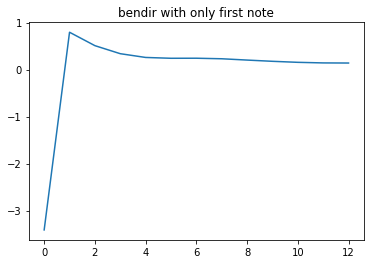

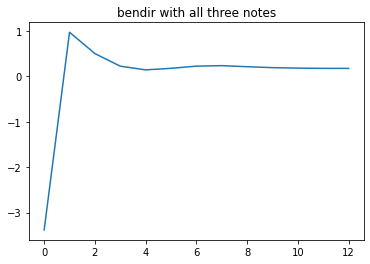

In [ ]:
plt.figure()
plt.title('bendir with only first note')
plt.plot(preprocessing.scale(feat['lowlevel.mfcc.mean']))
plt.figure()
plt.title('bendir with all three notes')
plt.plot(preprocessing.scale(feat2['lowlevel.mfcc.mean']))


I wanted to see if there was a difference if I calculated the MFCC for my sound with only the first hit on the drum and the MFCC for all the 3 hits on the drum. as you can see on the plot above the difference is so miniscule it doesnt really matter so im keeping the sound with three hits on the drum for the classification. 


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


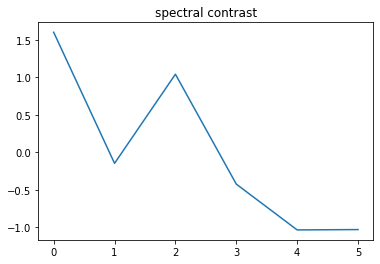

In [ ]:
plt.figure()
plt.title('spectral contrast')
plt.plot(preprocessing.scale(feat2['lowlevel.spectral_contrast_coeffs.mean']))

For The classification I am going to use first and third mel frequency cepstrum coefficients because I think it would be interesting to see what happens because the first coefficient is so different to the rest and after the third one it is pretty much the same. Then I am going to use the 3rd spectral contrast because of the peak it produces in the plot


dict_keys(['hi-hat', 'snare', 'bassdrum'])
[[0.28841328620910645, 0.6640064716339111, 0.9830374717712402, 0.8633610606193542, 1.0076978206634521, 1.0276933908462524, 1.0501573085784912, 0.9687434434890747, 0.9470881223678589, 0.8200232982635498, 0.7156316637992859, 0.6434131860733032, 0.5962969064712524]]


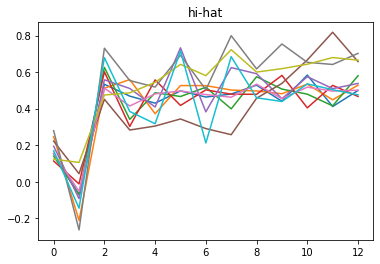

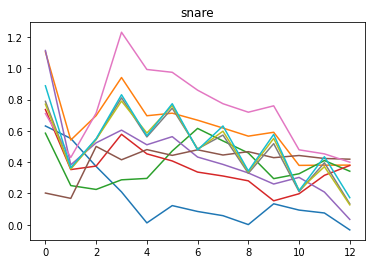

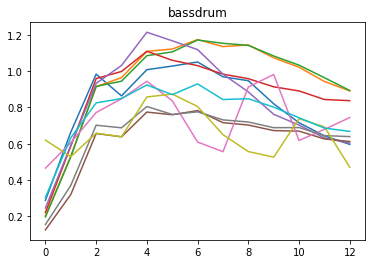

In [ ]:
def fetchDataDetails(inputDir, descExt = '.json'):
  """
  This function is used by other functions to obtain the information regarding the directory structure 
  and the location of descriptor files for each sound 
  """
  dataDetails = {}
  for path, dname, fnames  in os.walk(inputDir):
    for fname in fnames:
      if descExt in fname.lower():
        remain, rname, cname, sname = path.split('/')[:-3], path.split('/')[-3], path.split('/')[-2], path.split('/')[-1]
        if cname not in dataDetails:
          dataDetails[cname]={}
        fDict = json.load(open(os.path.join('/'.join(remain), rname, cname, sname, fname),'r'))
        dataDetails[cname][sname]={'file': fname, 'feature':fDict}
  return dataDetails


data = fetchDataDetails('/content/drive/MyDrive/sms-tools/sounds/sounds')

print(data.keys())
print(data['bassdrum']['195747']['feature']['lowlevel.mfcc.mean'])

for categories in data.keys():
  plt.figure()
  for files in data[categories].keys():
    plt.title(categories)
    plt.plot(data[categories][files]['feature']['lowlevel.mfcc.mean'][0])
    




Here above I plot the MFCC for all of the other instruments. I wanted to see if there was some correlation between the MFCC in the sounds. As you can see all the sounds for their respected instrument are very similar

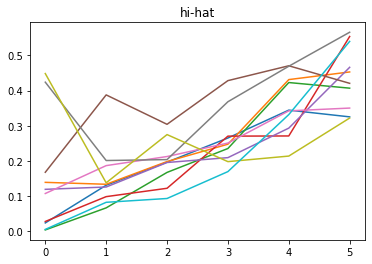

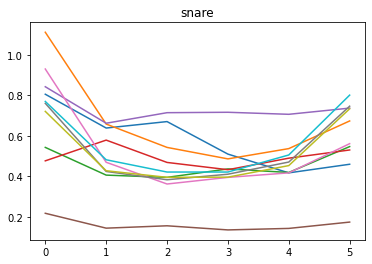

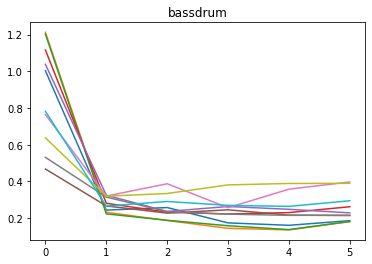

In [ ]:
for categories in data.keys():
  plt.figure()
  for files in data[categories].keys():
    plt.title(categories)
    plt.plot(data[categories][files]['feature']['lowlevel.spectral_contrast.mean'][0])


Here above I plot the spectral contrast for respected instrument. notable is that one snare is a little bit different than the other snare but all the other sounds are very similar

In [ ]:
descriptorMapping = { 0: 'lowlevel.spectral_centroid.mean',
                      1: 'lowlevel.dissonance.mean',
                      2: 'lowlevel.hfc.mean',
                      3: 'sfx.logattacktime.mean',
                      4: 'sfx.inharmonicity.mean',
                      5: 'lowlevel.spectral_contrast.mean.0',
                      6: 'lowlevel.spectral_contrast.mean.1',
                      7: 'lowlevel.spectral_contrast.mean.2',
                      8: 'lowlevel.spectral_contrast.mean.3',
                      9: 'lowlevel.spectral_contrast.mean.4',
                      10: 'lowlevel.spectral_contrast.mean.5',
                      11: 'lowlevel.mfcc.mean.0',
                      12: 'lowlevel.mfcc.mean.1',
                      13: 'lowlevel.mfcc.mean.2',
                      14: 'lowlevel.mfcc.mean.3',
                      15: 'lowlevel.mfcc.mean.4',
                      16: 'lowlevel.mfcc.mean.5'
                    }

In [ ]:
def convFtrDict2List(ftrDict):
  """
  This function converts descriptor dictionary to an np.array. The order in the numpy array (indices) 
  are same as those mentioned in descriptorMapping dictionary.
  
  Input: 
    ftrDict (dict): dictionary containing descriptors downloaded from the freesound
  Output: 
    ftr (np.ndarray): Numpy array containing the descriptors for processing later on
  """
  ftr = []
  for key in range(len(descriptorMapping.keys())):
    try:
      ftrName, ind = '.'.join(descriptorMapping[key].split('.')[:-1]), int(descriptorMapping[key].split('.')[-1])
      ftr.append(ftrDict[ftrName][0][ind])
    except:
      ftr.append(ftrDict[descriptorMapping[key]][0])
  return np.array(ftr)


In [ ]:
def cluster_sounds(targetDir, nCluster = -1, descInput=[]):
  """
  This function clusters all the sounds in targetDir using kmeans clustering.
  
  Input:
    targetDir (string): Directory where sound descriptors are stored (all the sounds in this 
                        directory will be used for clustering)
    nCluster (int): Number of clusters to be used for kmeans clustering.
    descInput (list) : List of indices of the descriptors to be used for similarity/distance 
                       computation (see descriptorMapping)
  Output:
    Prints the class of each cluster (computed by a majority vote), number of sounds in each 
    cluster and information (sound-id, sound-class and classification decision) of the sounds 
    in each cluster. Optionally, you can uncomment the return statement to return the same data.
  """
  
  dataDetails = fetchDataDetails(targetDir)
  
  ftrArr = []
  infoArr = []
  
  if nCluster ==-1:
    nCluster = len(dataDetails.keys())
  for cname in dataDetails.keys():
    #iterating over sounds
    for sname in dataDetails[cname].keys():
      ftrArr.append(convFtrDict2List(dataDetails[cname][sname]['feature'])[descInput])
      infoArr.append([sname, cname])
  
  ftrArr = np.array(ftrArr)
  infoArr = np.array(infoArr)
  
  ftrArrWhite = whiten(ftrArr)
  centroids, distortion = kmeans(ftrArrWhite, nCluster)
  clusResults = -1*np.ones(ftrArrWhite.shape[0])
  
  for ii in range(ftrArrWhite.shape[0]):
    diff = centroids - ftrArrWhite[ii,:]
    diff = np.sum(np.power(diff,2), axis = 1)
    indMin = np.argmin(diff)
    clusResults[ii] = indMin
  
  ClusterOut = []
  classCluster = []
  globalDecisions = []  
  for ii in range(nCluster):
    ind = np.where(clusResults==ii)[0]
    freqCnt = []
    for elem in infoArr[ind,1]:
      freqCnt.append(infoArr[ind,1].tolist().count(elem))
    indMax = np.argmax(freqCnt)
    classCluster.append(infoArr[ind,1][indMax])
    
    print("\n(Cluster: " + str(ii) + ") Using majority voting as a criterion this cluster belongs to " + 
          "class: " + classCluster[-1])
    print ("Number of sounds in this cluster are: " + str(len(ind)))
    decisions = []
    for jj in ind:
        if infoArr[jj,1] == classCluster[-1]:
            decisions.append(1)
        else:
            decisions.append(0)
    globalDecisions.extend(decisions)
    print ("sound-id, sound-class, classification decision")
    ClusterOut.append(np.hstack((infoArr[ind],np.array([decisions]).T)))
    print (ClusterOut[-1])
  globalDecisions = np.array(globalDecisions)
  totalSounds = len(globalDecisions)
  nIncorrectClassified = len(np.where(globalDecisions==0)[0])
  print("Out of %d sounds, %d sounds are incorrectly classified considering that one cluster should "
        "ideally contain sounds from only a single class"%(totalSounds, nIncorrectClassified))
  print("You obtain a classification (based on obtained clusters and majority voting) accuracy "
         "of %.2f percentage"%round(float(100.0*float(totalSounds-nIncorrectClassified)/totalSounds),2))

In [ ]:
cluster_sounds("/content/drive/MyDrive/sms-tools/sounds/sounds/",nCluster = -1, descInput=[11,13, 7] )


(Cluster: 0) Using majority voting as a criterion this cluster belongs to class: snare
Number of sounds in this cluster are: 10
sound-id, sound-class, classification decision
[['270156' 'snare' '1']
 ['528461' 'snare' '1']
 ['212208' 'snare' '1']
 ['519279' 'snare' '1']
 ['528870' 'snare' '1']
 ['529378' 'snare' '1']
 ['543499' 'snare' '1']
 ['543497' 'snare' '1']
 ['543498' 'snare' '1']
 ['157584' 'bassdrum' '0']]

(Cluster: 1) Using majority voting as a criterion this cluster belongs to class: bassdrum
Number of sounds in this cluster are: 7
sound-id, sound-class, classification decision
[['195747' 'bassdrum' '1']
 ['20908' 'bassdrum' '1']
 ['20909' 'bassdrum' '1']
 ['188105' 'bassdrum' '1']
 ['20910' 'bassdrum' '1']
 ['157585' 'bassdrum' '1']
 ['157583' 'bassdrum' '1']]

(Cluster: 2) Using majority voting as a criterion this cluster belongs to class: hi-hat
Number of sounds in this cluster are: 13
sound-id, sound-class, classification decision
[['509972' 'hi-hat' '1']
 ['509969' 'h

As you can see above using the features I picked I get a very good clustering of ~87% accuracy

In [ ]:
def compute_similar_sounds(queryFile, targetDir, descInput = []):
  """
  This function returns similar sounds for a specific queryFile. Given a queryFile this function 
  computes the distance of the query to all the sounds found in the targetDir and sorts them in 
  the increasing order of the distance. This way we can obtain similar sounds to a query sound.
  
  Input:
    queryFile (string): Descriptor file (.json, unless changed)
    targetDir (string): Target directory to search for similar sounds (using their descriptor files)
    descInput (list) : list of indices of the descriptors to be used for similarity/distance computation 
                       (see descriptorMapping)
  Output: 
    List containing an ordered list of similar sounds. 
  """
  
  dataDetails = fetchDataDetails(targetDir)
  
  #reading query feature dictionary
  qFtr = json.load(open(queryFile, 'r'))
  dist = []
  # Iterating over classes
  for cname in dataDetails.keys():
    # Iterating over sounds
    for sname in dataDetails[cname].keys():
      f1 =  convFtrDict2List(qFtr)
      f2 =  convFtrDict2List(dataDetails[cname][sname]['feature'])
      eucDist = np.sqrt(np.sum(np.power(np.array(f1[descInput]) - np.array(f2[descInput]), 2)))
      dist.append([eucDist, sname, cname])
  
  # Sorting the array based on the distance
  indSort = np.argsort(np.array(dist)[:,0])
  return (np.array(dist)[indSort,:]).tolist()

        
def classify_sound_kNN(queryFile, targetDir, K, descInput = []):
  """
  This function performs the KNN classification of a sound. The nearest neighbors are chosen from 
  the sounds in the targetDir.
   
  Input:
    queryFile (string): Descriptor file (.json, unless changed)
    targetDir (string): Target directory to search for similar sounds (using their descriptor files)
    K (int) : Number of nearest neighbors to consider for KNN classification.
    descInput (list) : List of indices of the descriptors to be used for similarity/distance computation 
                      (see descriptorMapping)
  Output:
    predClass (string): Predicted class of the query sound
  """
  distances = compute_similar_sounds(queryFile, targetDir, descInput)
  if len(np.where((np.array(distances)[:,0].astype(np.float64))==0)[0])>0:
    print("Warning: We found an exact copy of the query file in the target directory. "
          "Beware of duplicates while doing KNN classification.")
  
  classes = (np.array(distances)[:K,2]).tolist()
  freqCnt = []
  for ii in range(K):
    freqCnt.append(classes.count(classes[ii]))
  indMax = np.argmax(freqCnt)
  predClass =  classes[indMax]
  print ("This sample belongs to class: " + str(predClass))
  return predClass

In [ ]:
for i in range(1,11):
  classify_sound_kNN('/content/drive/MyDrive/sms-tools/sounds/MySound.json', '/content/drive/MyDrive/sms-tools/sounds/sounds/', i, descInput = [11,13,7])


This sample belongs to class: hi-hat
This sample belongs to class: hi-hat
This sample belongs to class: hi-hat
This sample belongs to class: hi-hat
This sample belongs to class: hi-hat
This sample belongs to class: hi-hat
This sample belongs to class: hi-hat
This sample belongs to class: hi-hat
This sample belongs to class: hi-hat
This sample belongs to class: hi-hat


# I added the features form essentia of my sound to a json file and normalized them and did a classification with 10 different k values. every time the classifier says the sample belongs to hi-hat. It could be because the MFCC of my sound and the hi-hat follow a very similar trend. But the spectral contrast seams to follow more of the bassdrum's trend. other conclusion could be that the hi-hat sound is very stochastic and so is my sound so it makes sense that the classifier classifies my sound to be a hi-hat.